<h1>Estimating potential economic losses from wildfires<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

### Goal: 

Given a hazard index indicating the probability of wildfires, come up with metrics that indicate potential economic losses in the endangered areas

### Strategy:

- import hazard index 
    - import and study the raw data
    - pick area of interest
- import data on the topography from openstreetmaps, study the individual parts
    - extract builing footprints
    - points of interest
    - network centrality
    - landuse
- convert into metrics correlated with economic losses 
    - size of building (area)
    - category of point of interest (value)
    - centrality of location (real estate price level)
    - landuse category (high-value (winery etc) or farmland)
- spatial merge the hazard index grid with the points and polygons with economic measures attached to them
- aggregate economic measures by pixel grid
- combine economic measures into an index
- analyse the resuly

# Notebook preparation

In [1]:
# Make sure script changes take effect within this session
%load_ext autoreload
%autoreload 2

In [2]:
# import some useful packages for this analysis
from setup import *

# Import hazard index

## import and study the raw data
### Load the json from kepler.gl

In [3]:
# read in the main datafile
json_file = json.load(open('../data/keplergl.json'))

### Convert the json file to geopandas dfs

Unfortunately, the json file can't be read directly into a GeoDataFrame using geopandas, because it contains five different datasets, and because the individual datasets' structure was not recognised by geopandas. Therefore, I have to implement a manual conversion of the json file into five dataframes, holding the individual layers.

The hazard data is in the first dataset, which I save in df1. The remaining dfs hold the shapes of the fires. 

In [4]:
json_file

{'datasets': [{'version': 'v1',
   'data': {'id': '24645u33j',
    'label': 'hc17_ZZfnd25_N1k_1000_I1.geojson',
    'color': [143, 47, 191],
    'allData': [[{'type': 'Feature',
       'properties': {'date': '2019-10-01 00:00', 'I1': 1, 'index': 0},
       'geometry': {'type': 'Polygon',
        'coordinates': [[[-121.0677943024656, 42.0517121830832],
          [-121.0677943024656, 42.0414448987341],
          [-121.0369924494183, 42.0414448987341],
          [-121.0369924494183, 42.0517121830832],
          [-121.0677943024656, 42.0517121830832]]]}},
      '2019-10-01 00:00',
      1],
     [{'type': 'Feature',
       'properties': {'date': '2019-10-01 00:00', 'I1': 1, 'index': 1},
       'geometry': {'type': 'Polygon',
        'coordinates': [[[-121.09859615551288, 42.0414448987341],
          [-121.09859615551288, 42.031177614385],
          [-121.08832887116378, 42.031177614385],
          [-121.08832887116378, 42.0414448987341],
          [-121.09859615551288, 42.0414448987341]]]}

In [5]:
# Initialise pandas dfs to hold the datasets
df1, df2, df3, df4, df5 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
dfs = [df1, df2, df3, df4, df5]

# Create a df for each dataset in turn
for dataset in range(5):
    
    # get actual data from json
    data = json_file['datasets'][dataset]['data']['allData']
    
    # turn into df
    dfs[dataset] = pd.DataFrame(data)
    
    # extract coordinates
    dfs[dataset].loc[:,'geometry'] = dfs[dataset][0].map(lambda x: x['geometry']['coordinates'][0])
    
    # create polygons in list
    if json_file['datasets'][dataset]['data']['allData'][0][0]['geometry']['type'] == 'Polygon':
        rows = dfs[dataset].geometry.to_list()    
        geometry = [Polygon(xy) for xy in rows]
        
        # drop columns we don't need
        dfs[dataset] = dfs[dataset].iloc[:,1:3]
    
        # rename columns
        dfs[dataset].columns = ['date', 'level']
        dfs[dataset].date = pd.to_datetime(dfs[dataset].date)
        
    # create geometry column based on structure of the individual datasets
    elif json_file['datasets'][dataset]['data']['allData'][0][0]['geometry']['type'] == 'MultiPolygon':
        rows = dfs[dataset].geometry[0]
        if len(rows) > 1:
            polygons = []
            for row in rows:
                polygons.append(Polygon(row))
            geometry = [MultiPolygon(polygons)]
            
        else: 
            geometry = [Polygon(xy) for xy in rows] 
    
    # Make sure to use the same crs throughout the project
    crs = {'init': 'epsg:4326'}

    # Create GDF
    dfs[dataset] = gpd.GeoDataFrame(dfs[dataset], crs=crs, geometry=geometry)

### Inspect the hazard index data

I begin my inspection with the main dataset that's in df1. It looks like we have 511870 pixel-time datapoints with a fire hazard index score. However, there seem to be some pixel-time points which we have to discard, because they have negative index values, which doesn't make sense. 

In [6]:
# The hazard index data sits in the first df, the other dfs have the coordinates for the fires
main_df = dfs[0]
main_df

,date,level,geometry
0,2019-10-01,1,"POLYGON ((-121.06779 42.05171, -121.06779 42.0..."
1,2019-10-01,1,"POLYGON ((-121.09860 42.04144, -121.09860 42.0..."
2,2019-10-01,3,"POLYGON ((-121.08833 42.04144, -121.08833 42.0..."
3,2019-10-01,4,"POLYGON ((-121.07806 42.04144, -121.07806 42.0..."
4,2019-10-01,2,"POLYGON ((-121.03699 42.04144, -121.03699 42.0..."
...,...,...,...
518865,2019-10-08,4,"POLYGON ((-119.17861 36.91807, -119.17861 36.9..."
518866,2019-10-08,3,"POLYGON ((-119.16835 36.91807, -119.16835 36.9..."
518867,2019-10-08,2,"POLYGON ((-119.15808 36.91807, -119.15808 36.9..."
518868,2019-10-08,1,"POLYGON ((-119.33262 36.90780, -119.33262 36.8..."


It looks like the index goes from 0 to 999.

In [7]:
main_df.describe()

,level
count,"518,870"
mean,41
std,"1,300"
min,"-32,767"
25%,12
50%,41
75%,112
max,989


Let's discard the datapoints which have incorrect index values:

In [8]:
main_df[main_df.level < 0]

,date,level,geometry
1283,2019-10-01,-32767,"POLYGON ((-121.10886 41.90797, -121.10886 41.8..."
1420,2019-10-01,-32767,"POLYGON ((-121.20127 41.88744, -121.20127 41.8..."
2132,2019-10-01,-32767,"POLYGON ((-122.59762 41.83610, -122.59762 41.8..."
3517,2019-10-01,-32767,"POLYGON ((-122.47441 41.77450, -122.47441 41.7..."
3862,2019-10-01,-32767,"POLYGON ((-122.25880 41.73343, -122.25880 41.7..."
...,...,...,...
516359,2019-10-08,-32767,"POLYGON ((-119.71251 37.21582, -119.71251 37.2..."
517515,2019-10-08,-32767,"POLYGON ((-121.13967 37.08235, -121.13967 37.0..."
517543,2019-10-08,-32767,"POLYGON ((-121.75570 37.07208, -121.75570 37.0..."
518203,2019-10-08,-32767,"POLYGON ((-121.68383 36.98994, -121.68383 36.9..."


In [9]:
main_df = main_df[main_df.level > 0]

Just to get an idea of how this index is distributed, let's look at histograms. Also, let's compare the development of the index over the eight days we've got data for:

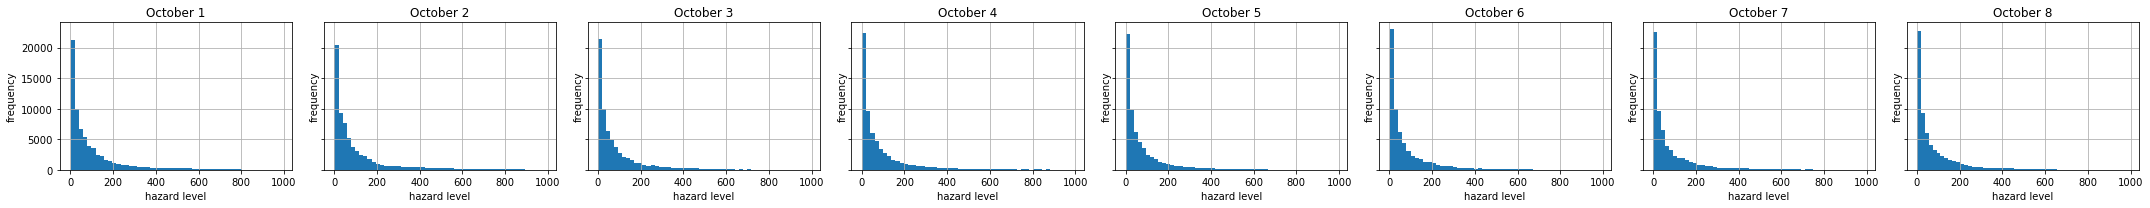

In [10]:
# Hazard index histograms per day
fig, axes = plt.subplots(nrows=1,ncols=8, figsize = (30, 3), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.4)

for day in range(1,9,1):
    main_df[main_df.date == dt.datetime(2019, 10, day)].hist(bins = 50, ax = axes[day-1])
    axes[day-1].set(title = 'October ' + str(day), ylabel = 'frequency', xlabel = 'hazard level')

plt.tight_layout();
plt.show()

Difficult to tell the difference. Let's zoom in a bit:

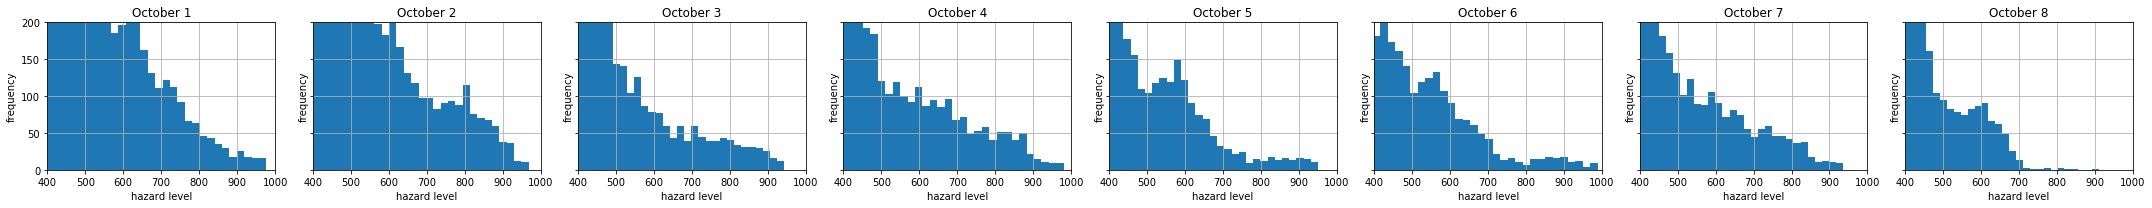

In [11]:
# Hazard index histograms per day, zoomed
fig, axes = plt.subplots(nrows=1,ncols=8, figsize = (30, 3), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.4)

for day in range(1,9,1):
    main_df[main_df.date == dt.datetime(2019, 10, day)].hist(bins = 50, ax = axes[day-1])
    axes[day-1].set(title = 'October ' + str(day), ylabel = 'frequency', xlabel = 'hazard level')

axes[0].set_xlim(400, 1000); axes[0].set_ylim(0, 200);
plt.tight_layout();
plt.show()

**Looks like the hazard is reducing a bit, at least the areas with very high risk seem to be reducing.**

## Pick area of interest

Now that we have a bit of an idea of the hazard index dataset, let's pick an area of interest:
I will study an area around the Santa Rosa fire of 2017.

In [12]:
# Select the df of the Santa Rosa fire
fire_area = dfs[1].loc[:,['geometry']]
fire_area

,geometry
0,"POLYGON ((-122.75937 38.52304, -122.75925 38.5..."


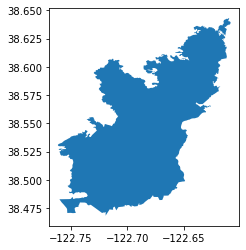

In [13]:
# Have a look at the result
fire_area.plot()

We also want to include the area around the fire. Therefore, we pick the center of the fire and anything 50km above, below, to the left and right.

In [14]:
fire_centre = fire_area.centroid

In [15]:
# The centroid of the fire
fire_centre = (fire_centre[0].xy[1][0],fire_centre[0].xy[0][0])
fire_centre

(38.54696115613171, -122.68515427508606)

In [16]:
# 50km - just large enough to have interesting topological variation, and small enough to process on a laptop
distance = 50000

In [116]:
# Make a box around the centroid, 10000 sqkm
focus_area = ox.bbox_from_point(fire_centre, distance)
focus_area

(38.99753977362432, 38.09634767927647, -122.1114170328413, -123.25893542934972)

This is our area of interest:

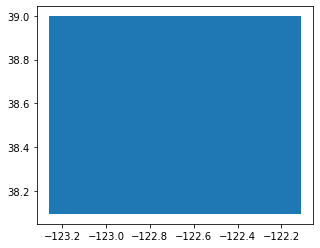

In [117]:
# Create a Polygon, then a GeoSeries, which makes it easier to merge with GeoDataFrames
focus_area = Polygon([(focus_area[2], focus_area[0]), (focus_area[3], focus_area[0]), (focus_area[3], focus_area[1]), (focus_area[2], focus_area[1])])
focus_area_gdf = gpd.GeoSeries(focus_area, crs = crs)

# Check the result
focus_area_gdf.plot()

In [19]:
# Confirm we have the right crs
focus_area_gdf.crs

{'init': 'epsg:4326'}

Now that we have identified a focus area, let's download some data for this area. A tool relied on by many for this is openstreetmaps.
Other potential data sources on infrastructure, roads etc are of course available, but are often propietary or more time-consuming to access.

# Import data on the topography from openstreetmaps

## Roads 

Roads help us identify density, which is an important correlate with real estate prices.

### Download road data

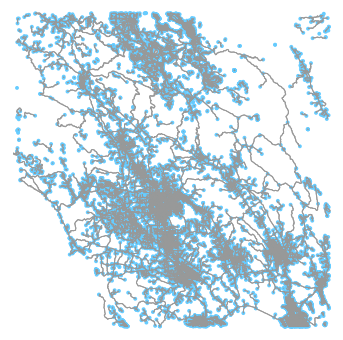

In [84]:
# Download all roads accesible to cars in our area of interest
roads = ox.graph_from_point(fire_centre, distance, network_type='drive', simplify=True, retain_all=True)

# Have a look at the result
fig, ax = ox.plot_graph(roads)

### Extract centrality measure

A good proxy for real estate prices are network centrality measures. A simple way to get these for the road network graph in our area of interest, is to create a NetowrkX graph object.
Many centrality measures could be tried. I'll have a go with Pagerank.

In [85]:
# Calculate centrality measures
roads_stats = ox.stats.extended_stats(roads)

In [86]:
# Which measures are available?
roads_stats.keys()

dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min'])

In [87]:
# let's save the pagerank measure
pagerank = roads_stats['pagerank']
pagerank

{55953207: 3.270224589069872e-05,
 55959637: 3.419006007414109e-05,
 55960455: 4.340977567412052e-05,
 55960458: 3.69519855738074e-05,
 55960468: 1.6093094303096023e-05,
 55960494: 1.3413949349080429e-05,
 55960747: 3.9939101923942185e-05,
 55960758: 1.4580165682588538e-05,
 55960760: 4.662106324648812e-06,
 55962294: 1.1435286558365949e-05,
 55963180: 2.6926758298986743e-05,
 55963182: 2.6926758298986743e-05,
 55964386: 6.813447847187152e-05,
 55964388: 3.225384350419137e-05,
 55964390: 1.1353477056578277e-05,
 55964397: 9.44005895578369e-06,
 55964399: 7.860812655917734e-06,
 55964456: 3.3354507398581063e-05,
 55964458: 3.505360234160785e-05,
 55964460: 1.2127765160633839e-05,
 55964675: 8.545637977585647e-06,
 55964677: 8.61053789858202e-06,
 55965430: 3.273409092450889e-05,
 55965436: 8.871876483539988e-06,
 55968425: 2.8029435313432025e-05,
 55968426: 4.829252704782436e-05,
 55968563: 2.6926758298986743e-05,
 55968569: 2.6926758298986743e-05,
 55970199: 1.731166400540849e-05,
 559

### Store centrality measure results in geodataframe, for later merging with our main data

In [88]:
# Create GDFs from the Networkx graph
nodes, edges = ox.graph_to_gdfs(roads)

In [89]:
# Project it to our crs
edges = ox.project_gdf(edges, to_crs = crs)
nodes = ox.project_gdf(nodes, to_crs = crs)

In [90]:
# These are the edges
edges.head()

,u,v,key,osmid,ref,name,highway,maxspeed,oneway,length,geometry,lanes,bridge,access,junction,tunnel,width
0,55953207,56018169,0,7719964,CA 1,Coast Highway,primary,55 mph,False,"1,477","LINESTRING (-123.10196 38.41885, -123.10198 38...",NaN,NaN,NaN,NaN,NaN,NaN
1,55953207,56004988,0,7719964,CA 1,Coast Highway,primary,55 mph,False,"1,042","LINESTRING (-123.10196 38.41885, -123.10142 38...",NaN,NaN,NaN,NaN,NaN,NaN
2,55953207,55953209,0,7699449,NaN,NaN,residential,NaN,False,247,"LINESTRING (-123.10196 38.41885, -123.10396 38...",NaN,NaN,NaN,NaN,NaN,NaN
3,55959637,55959638,0,7700350,NaN,NaN,residential,NaN,False,127,"LINESTRING (-122.87007 38.37884, -122.86930 38...",NaN,NaN,NaN,NaN,NaN,NaN
4,55959637,56011029,0,7715716,NaN,Sexton Road,residential,NaN,False,244,"LINESTRING (-122.87007 38.37884, -122.87053 38...",NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# These are the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
55953207,38,-123,55953207,NaN,NaN,POINT (-123.10196 38.41885)
55959637,38,-123,55959637,NaN,NaN,POINT (-122.87007 38.37884)
55960455,38,-123,55960455,NaN,NaN,POINT (-122.89769 38.39522)
55960458,38,-123,55960458,NaN,NaN,POINT (-122.89690 38.39592)
55960468,38,-123,55960468,NaN,NaN,POINT (-122.89652 38.39732)


In [92]:
# Join the pagerank measures to the nodes
nodes.loc[:,'pagerank'] = nodes.osmid.map(lambda x: pagerank[x])

In [93]:
# Have a look at the result
nodes.head()

,y,x,osmid,highway,ref,geometry,pagerank
55953207,38,-123,55953207,NaN,NaN,POINT (-123.10196 38.41885),0
55959637,38,-123,55959637,NaN,NaN,POINT (-122.87007 38.37884),0
55960455,38,-123,55960455,NaN,NaN,POINT (-122.89769 38.39522),0
55960458,38,-123,55960458,NaN,NaN,POINT (-122.89690 38.39592),0
55960468,38,-123,55960468,NaN,NaN,POINT (-122.89652 38.39732),0


In [94]:
# create df
nodes_df = nodes.loc[:,['geometry', 'pagerank']]

In [95]:
nodes_df

,geometry,pagerank
55953207,POINT (-123.10196 38.41885),0
55959637,POINT (-122.87007 38.37884),0
55960455,POINT (-122.89769 38.39522),0
55960458,POINT (-122.89690 38.39592),0
55960468,POINT (-122.89652 38.39732),0
...,...,...
6940022523,POINT (-122.73977 38.43978),0
6953369271,POINT (-122.78830 38.46174),0
6953369272,POINT (-122.78990 38.46173),0
6965086986,POINT (-122.69890 38.45990),0


## Buildings

The area taken up by buildings is a good proxy of the value of property present in a certain pixel.

### Download building footprints

In [30]:
# Download all building footprints in our focus area
buildings = ox.footprints.footprints_from_point(fire_centre, distance, footprint_type='building')

In [31]:
# Have a look at the result
buildings.head()

,nodes,building,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,alt_name,amenity,name,website,source,contact:email,contact:website,cuisine,opening_hours,description,shop,phone,addr:state,tourism,attraction,sport,name:en,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,building:levels,access,operator,unisex,construction,use,building:use,content,man_made,outdoor_seating,religion,fee,female,addr:country,addr:province,colour,design,wall,height,building:structure,building:levels:underground,...,building:part,branch,bulk_purchase,automated,self_service,rooms,stars,noaddress,restaurant,WLAN,coffee,payment:american_express,payment:cfn,payment:discover_card,payment:fleet_card,payment:mastercard,payment:visa,payment:voyager,payment:wright_express,service:vehicle:air_conditioning,service:vehicle:batteries,service:vehicle:brakes,service:vehicle:car_repair,service:vehicle:diagnostics,service:vehicle:inspection,service:vehicle:transmission_repair,service:vehicle:tyres,service:vehicle:wheels,abandoned:name,animal_boarding,community_centre:for,wlan,car_wash,communication:microwave,tower:construction,tower:type,government,service:vehicle:transmission,service:vehicle:truck_repair,type,is_in:city,roof:orientation,members,addr:district,old_name,service:vehicle:oil_change,service:vehicle:suspension,service:vehicle:tire_rotation,service:vehicle:tires,service:vehicle:glass
33826998,"[387497384, 387497388, 2723891676, 387497392, ...",barn,"POLYGON ((-122.95505 38.18935, -122.95457 38.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33827005,"[387497504, 387497505, 387497506, 387497507, 3...",yes,"POLYGON ((-122.95429 38.19004, -122.95409 38.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38819259,"[460519701, 460519703, 460519705, 460519708, 4...",yes,"POLYGON ((-122.96676 38.25025, -122.96669 38.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178234042,"[1886013738, 1886013730, 1886013728, 188601372...",yes,"POLYGON ((-122.96495 38.24989, -122.96475 38.2...",Dillon Beach,1,94929,Beach Avenue,Dillon Beach Cafe,restaurant,Dillon Beach Resort,https://www.dillonbeachresort.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215919562,"[2253307981, 2253307982, 2253307980, 225330797...",yes,"POLYGON ((-122.93882 38.35589, -122.93872 38.3...",NaN,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [32]:
# Which unique building types are there?
buildings.building.unique()

array(['barn', 'yes', 'greenhouse', 'hotel', 'residential', 'house',
       'detached', 'commercial', 'school', 'service', 'gasstation',
       'farm', 'ruins', 'industrial', 'retail', 'storage_tank', 'roof',
       'warehouse', 'cabin', 'shed', 'garage', 'cowshed', 'stable',
       'garages', 'hospital', 'apartments', 'castle', 'office', 'college',
       'Bayview South', 'clinic', 'no', 'vacant', 'church', 'stadium',
       'brewery', 'shelter', 'hut', 'government', 'university', 'chapel',
       'terrace', 'train_station', 'public', 'static_caravan', 'carport',
       'parking', 'supermarket', 'construction', 'kindergarten', 'Home',
       'monastery', 'civic', 'semidetached_house', 'grandstand'],
      dtype=object)

In [33]:
# Make sure we apply our project crs
buildings = ox.project_gdf(buildings, to_crs = crs)

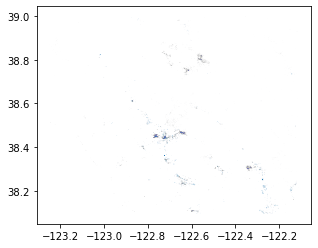

In [34]:
# Have a look at the result
buildings.plot()

### Extract building size / area of footprint

In [35]:
# Compute the area of building footprints
buildings_proj = ox.project_gdf(buildings)
areas = buildings_proj.area

### Store building area results in geodataframe, for later merging with our main data

In [36]:
# join to geodataframe
buildings = buildings.assign(building_area = areas)

# reset index so we have a UID
buildings = buildings.reset_index()

# Rename columns
buildings = buildings.rename(columns = {'index' : 'ID'})

# Select only columns we will need later
buildings_df = buildings.loc[:,['ID', 'geometry', 'building', 'amenity', 'building_area']]

## Points of interest

Points of interest give us good information specifically on larger infrastructure, and allow us to introduce value categories.

### Download points of interest

In [37]:
# Download all POIs in our focus area
poi = ox.pois.pois_from_point(fire_centre, distance)

In [38]:
# Project to our project crs
poi = ox.project_gdf(poi, to_crs = crs)

# Clean out amenities without name and parkings
poi[(poi.amenity != 'parking') & (poi.amenity.notna())].head()

,osmid,geometry,amenity,name,wheelchair,element_type,cuisine,ele,gnis:Class,gnis:County,gnis:County_num,gnis:ST_alpha,gnis:ST_num,gnis:id,import_uuid,is_in,note,sport,created_by,atm,brand,brand:wikidata,brand:wikipedia,fuel:lpg,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,fixme,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,operator,website,designation,source,gnis:edited,wikidata,religion,wikipedia,denomination,emergency,phone,addr:country,building,reviewed,gnis:county_name,gnis:import_uuid,...,drive_in,operator:website,deli,leisure,contact:email,roof:levels,diet:vegan,diet:vegetarian,building:use,recycling:plastic,levels,fuel:diesel,fuel:octane_87,fuel:octane_89,fuel:octane_91,grades,building:colour,building:material,roof:shape,parking_space,community,community:gender,building:part,bench,location,branch,bulk_purchase,organic,capacity:charging,opening_hours:signed,recycling:aluminium,recycling:batteries,recycling:cardboard,recycling:electrical_appliances,recycling:paper,recycling:scrap_metal,fuel:svo,automated,self_service,club,ref,animal_boarding,community_centre:for,wlan,toilets,toilets:access,toilets:wheelchair,access:disabled,type,ways
126854379,126854379,POINT (-122.70558 38.32603),bar,The Tradewinds,yes,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126854387,126854387,POINT (-122.70602 38.32598),bar,Spancky's,limited,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150944832,150944832,POINT (-122.92065 38.19939),restaurant,Nick's Cove,NaN,node,seafood,2,Populated Place,Marin,041,CA,06,252749,bb7269ee-502a-5391-8056-e3ce0e66489c,"Marin,California,Calif.,CA,USA",Oister Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309568800,309568800,POINT (-122.13536 38.24362),toilets,NaN,NaN,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309569393,309569393,POINT (-122.13664 38.24325),bench,NaN,NaN,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extract values: Assign points of interest to value categories

In [39]:
# Extract all unique types of amenities included in dataset
poi_list = poi.amenity.unique().tolist()
poi_list

['bar',
 'restaurant',
 'parking',
 'toilets',
 'bench',
 'bicycle_parking',
 'fuel',
 'school',
 'grave_yard',
 'theatre',
 'place_of_worship',
 'hospital',
 'post_office',
 'college',
 'community_centre',
 'arts_centre',
 'fire_station',
 'library',
 'prison',
 'townhall',
 nan,
 'fountain',
 'pool',
 'drinking_water',
 'horse_water',
 'fast_food',
 'police',
 'vending_machine',
 'cafe',
 'post_box',
 'ferry_terminal',
 'pub',
 'atm',
 'bank',
 'bus_station',
 'clinic',
 'swimming_pool',
 'sanitary_dump_station',
 'parking_entrance',
 'telephone',
 'veterinary',
 'pharmacy',
 'cinema',
 'boat_rental',
 'car_wash',
 'waste_disposal',
 'waste_basket',
 'watering_place',
 'ranger_station',
 'dentist',
 'bicycle_rental',
 'doctors',
 'shelter',
 'kindergarten',
 'ice_cream',
 'recycling',
 'bicycle_repair_station',
 'marketplace',
 'casino',
 'studio',
 'social_centre',
 'compressed_air',
 'dojo',
 'clock',
 'charging_station',
 'loading_dock',
 'music_venue',
 'public_bookcase',
 'car_r

Mock data for the worth of these structures.

In [40]:
# Mock values
values = {'small' : 50000,
         'medium': 500000,
         'large' : 5000000}

# Let's start with assigning amenities to the medium type
medium_infrastructure = ['bar', 'restaurant', 'place_of_worship', 'post_office', 'fast_food', 'cafe',
       'pub', 'bank', 'veterinary', 'pharmacy','boat_rental', 'waste_disposal', 'ranger_station', 'dentist',
       'bicycle_rental', 'doctors', 'shelter', 'kindergarten', 'ice_cream', 'recycling', 'bicycle_repair_station',
       'marketplace', 'casino', 'studio', 'social_centre', 'childcare', 'nightclub', 'coworking_space', 
       'social_facility', 'food_court', 'tool_library', 'crematorium', 'office', 'bureau_de_change', 'courthouse', 
       'spa', 'scrapyard', 'trailer_park', 'monastery', 'planetarium', 'club', 'animal_shelter',
       'animal_boarding', 'music_school', 'events_venue']

In [41]:
# Check which amenities we haven't assigned yet
from itertools import compress
allocated = [poi not in medium_infrastructure for poi in poi_list]
list(compress(poi_list, allocated))

['parking',
 'toilets',
 'bench',
 'bicycle_parking',
 'fuel',
 'school',
 'grave_yard',
 'theatre',
 'hospital',
 'college',
 'community_centre',
 'arts_centre',
 'fire_station',
 'library',
 'prison',
 'townhall',
 nan,
 'fountain',
 'pool',
 'drinking_water',
 'horse_water',
 'police',
 'vending_machine',
 'post_box',
 'ferry_terminal',
 'atm',
 'bus_station',
 'clinic',
 'swimming_pool',
 'sanitary_dump_station',
 'parking_entrance',
 'telephone',
 'cinema',
 'car_wash',
 'waste_basket',
 'watering_place',
 'compressed_air',
 'dojo',
 'clock',
 'charging_station',
 'loading_dock',
 'music_venue',
 'public_bookcase',
 'car_rental',
 'shower',
 'letter_box',
 'weighbridge',
 'public_building',
 'university',
 'car_pooling',
 'parking_space',
 'motorcycle_parking']

In [42]:
# Assign amenities to small type
small_infrastructure = ['parking',
                         'charging_station', 'toilets', 'bench', 'bicycle_parking', 'fountain', 'drinking_water',
                         'horse_water', 'vending_machine', 'post_box', 'atm', 'bus_station', 'sanitary_dump_station',
                         'parking_entrance', 'telephone', 'waste_basket', 'watering_place', 'compressed_air',
                         'dojo', 'clock', 'public_bookcase', 'shower', 'letter_box', 'weighbridge', 'car_pooling',
                         'parking_space', 'motorcycle_parking']

In [43]:
# Check which amenities we haven't assigned yet
from itertools import compress
allocated = [((poi not in medium_infrastructure) & (poi not in small_infrastructure)) for poi in poi_list]
list(compress(poi_list, allocated))

['fuel',
 'school',
 'grave_yard',
 'theatre',
 'hospital',
 'college',
 'community_centre',
 'arts_centre',
 'fire_station',
 'library',
 'prison',
 'townhall',
 nan,
 'pool',
 'police',
 'ferry_terminal',
 'clinic',
 'swimming_pool',
 'cinema',
 'car_wash',
 'loading_dock',
 'music_venue',
 'car_rental',
 'public_building',
 'university']

In [44]:
# Assign amenities to large type
large_infrastructure = ['fuel', 'school', 'grave_yard', 'theatre', 'hospital', 'college', 'community_centre', 'arts_centre',
                         'fire_station', 'library', 'prison', 'townhall', 'pool', 'police', 'ferry_terminal', 'clinic',
                         'swimming_pool', 'cinema', 'car_wash', 'loading_dock', 'music_venue', 'car_rental', 'public_building', 'university']

### Store POI value categorisation in geodataframe, for later merging with our main data

In [45]:
# Throw out uninteresting columns
poi_df = poi[poi.amenity.notna()].loc[:,['osmid', 'geometry', 'amenity', 'name']]

In [46]:
# Join value to GDF
def assign_value(name, values):
    if name in small_infrastructure:
        value = values['small']
    elif name in medium_infrastructure:
        value = values['medium']
    elif name in large_infrastructure:
        value = values['large']
    else:
        value = None
    return value
        
poi_df.loc[:,'value'] = poi_df.amenity.map(lambda x: assign_value(x, values))

In [47]:
# Have a look at the result
poi_df.head()

,osmid,geometry,amenity,name,value
126854379,126854379,POINT (-122.70558 38.32603),bar,The Tradewinds,500000
126854387,126854387,POINT (-122.70602 38.32598),bar,Spancky's,500000
150944832,150944832,POINT (-122.92065 38.19939),restaurant,Nick's Cove,500000
290050794,290050794,POINT (-123.01050 38.82313),parking,NaN,50000
309568800,309568800,POINT (-122.13536 38.24362),toilets,NaN,50000


## Landuse

Landuse categorisation let us identify whether there are farms or vineyards in the area that could be lost to a fire.

### Download land use data

In [48]:
# Download landuse
landuse = ox.footprints.footprints_from_point(fire_centre, distance = distance - 3000, footprint_type='landuse')

In [49]:
# Have a look at the result
landuse.head()

,nodes,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,landuse,name,geometry,natural,wikidata,water,wikipedia,ALAND,AREAID,AWATER,MTFCC,Tiger:MTFCC,latitude,longitude,source,ID,attribution,county,description,landuse:historic,addr:county,addr:postcode,addr:street,caltrans:district,caltrans:dynsegpm,caltrans:type,phone,route,building,building:levels,shop,wheelchair,FMMP_modified,FMMP_reviewed,acres,residential,golf,leisure,sport,addr:city,addr:state,operator,crop,...,COMM_CODE,DT_ADD,DT_MANT,NO_PRMT,NO_PRMT_SI,NO_SITE,OPER_ADD,area,capture,fields,fields_ID,PMT_SITE,P_S_COMM,trees,OPER_MANT,tiger:ALAND,tiger:AREAID,tiger:AWATER,tiger:COUNTYFP,tiger:STATEFP,tiger:reviewed,irrigated,ref,FMMP_verified,created_by,fruits,old_name,brand,brand:wikidata,brand:wikipedia,operator:wikidata,operator:wikipedia,tourism,note,level,addr:country,smoking,man_made,landcover,meadow,private,owner,leaf_type,members,csp:globalid,csp:unitcode,ownership,type,AREA,highway
33002302,"[371830875, 371830881, 371830886, 371830891, 3...",grave_yard,74,097,07/23/2003,1989451,06,cemetery,Sebastopol Memorial Lawn Cemetery,"POLYGON ((-122.83513 38.39816, -122.83511 38.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35081135,"[411551131, 411551132, 411551133, 411551134, 4...",NaN,30,097,07/20/1998,1799646,06,reservoir,Roberts Lake,"POLYGON ((-122.71101 38.36496, -122.71118 38.3...",water,Q7351870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35137888,"[412170053, 412170054, 412170059, 412170060, 4...",NaN,151,097,07/20/1998,1799345,06,reservoir,Fountaingrove Lake,"POLYGON ((-122.71932 38.48643, -122.71916 38.4...",water,Q5474836,reservoir,en:Fountaingrove Lake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35138319,"[412171401, 412171402, 412171403, 412171404, 4...",NaN,73,097,01/19/1981,230687,06,reservoir,Pine Creek Reservoir,"POLYGON ((-122.70622 38.46555, -122.70617 38.4...",water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38477729,"[454870475, 454870476, 454870477, 454870478, 4...",NaN,NaN,NaN,NaN,NaN,NaN,residential,NaN,"POLYGON ((-123.12205 38.44030, -123.12181 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Let's see which categories there are
landuse.landuse.unique()

array(['cemetery', 'reservoir', 'residential', 'military', 'forest',
       'vineyard', 'industrial', 'grass', 'retail', 'farmyard',
       'farmland', 'farm', 'commercial', 'orchard', 'railway',
       'allotments', 'recreation_ground', 'greenfield', 'quarry',
       'construction', 'churchyard', 'meadow', 'brownfield', 'landfill',
       'plant_nursery', 'park', 'religious', 'conservation', 'vacant'],
      dtype=object)

In [51]:
# Make sure we have the correct crs
landuse = ox.project_gdf(landuse, to_crs = crs)

### Extract farms, vineyards

We will categorise two value categories of land use: farmland and winecountry. While there are more, we can easily group the high-value multi-year crops to winecountry and the lower value types to farmland.

In [52]:
# Low value types
farm_categories = ['farmyard', 'farmland', 'farm']

In [53]:
# High value types
vineyard_categories = ['vineyard', 'orchard', 'plant_nursery']

In [54]:
# Sort for farms
farmland = landuse[landuse.landuse.isin(farm_categories)]

In [55]:
# Have a look at the result
farmland.head()

,nodes,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,landuse,name,geometry,natural,wikidata,water,wikipedia,ALAND,AREAID,AWATER,MTFCC,Tiger:MTFCC,latitude,longitude,source,ID,attribution,county,description,landuse:historic,addr:county,addr:postcode,addr:street,caltrans:district,caltrans:dynsegpm,caltrans:type,phone,route,building,building:levels,shop,wheelchair,FMMP_modified,FMMP_reviewed,acres,residential,golf,leisure,sport,addr:city,addr:state,operator,crop,...,COMM_CODE,DT_ADD,DT_MANT,NO_PRMT,NO_PRMT_SI,NO_SITE,OPER_ADD,area,capture,fields,fields_ID,PMT_SITE,P_S_COMM,trees,OPER_MANT,tiger:ALAND,tiger:AREAID,tiger:AWATER,tiger:COUNTYFP,tiger:STATEFP,tiger:reviewed,irrigated,ref,FMMP_verified,created_by,fruits,old_name,brand,brand:wikidata,brand:wikipedia,operator:wikidata,operator:wikipedia,tourism,note,level,addr:country,smoking,man_made,landcover,meadow,private,owner,leaf_type,members,csp:globalid,csp:unitcode,ownership,type,AREA,highway
116921300,"[1317055005, 1317029843, 1316879172, 131702967...",NaN,NaN,NaN,NaN,NaN,NaN,farmyard,NaN,"POLYGON ((-122.79735 38.22163, -122.79627 38.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.consrv.ca.gov/dlrp/fmmp/products/Pa...,NaN,Farmland Mapping and Monitoring Program,NaN,other land,NaN,Marin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,9.64510453024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116921315,"[1317046258, 1316998547, 1316986350, 131693044...",NaN,NaN,NaN,NaN,NaN,NaN,farmyard,Walker Creek Ranch (Marin Co. Office of Educat...,"POLYGON ((-122.81426 38.17564, -122.81376 38.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.consrv.ca.gov/dlrp/fmmp/products/Pa...,NaN,Farmland Mapping and Monitoring Program,NaN,other land,NaN,Marin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,15.5719479601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116921319,"[1317065152, 1317013442, 1316998619, 131694194...",NaN,NaN,NaN,NaN,NaN,NaN,farmyard,NaN,"POLYGON ((-122.94213 38.13556, -122.94118 38.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.consrv.ca.gov/dlrp/fmmp/products/Pa...,NaN,Farmland Mapping and Monitoring Program,NaN,other land,NaN,Marin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,19.1435651865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116921342,"[1316963158, 1316985975, 1316937479, 131692484...",NaN,NaN,NaN,NaN,NaN,NaN,farmyard,NaN,"POLYGON ((-122.91121 38.31673, -122.91133 38.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.consrv.ca.gov/dlrp/fmmp/products/Pa...,NaN,Farmland Mapping and Monitoring Program,NaN,other land,NaN,Marin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,13.3221176676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116921344,"[1317057102, 1316963535, 1316896833, 131699070...",NaN,NaN,NaN,NaN,NaN,NaN,farmland,NaN,"POLYGON ((-122.93850 38.15846, -122.93799 38.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.consrv.ca.gov/dlrp/fmmp/products/Pa...,NaN,Farmland Mapping and Monitoring Program,NaN,farmland of local importance,NaN,Marin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,87.2983432508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [56]:
# Sort for winecountry
winecountry = landuse[landuse.landuse.isin(vineyard_categories)]

In [57]:
# Have a look at the result
winecountry.head()

,nodes,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,landuse,name,geometry,natural,wikidata,water,wikipedia,ALAND,AREAID,AWATER,MTFCC,Tiger:MTFCC,latitude,longitude,source,ID,attribution,county,description,landuse:historic,addr:county,addr:postcode,addr:street,caltrans:district,caltrans:dynsegpm,caltrans:type,phone,route,building,building:levels,shop,wheelchair,FMMP_modified,FMMP_reviewed,acres,residential,golf,leisure,sport,addr:city,addr:state,operator,crop,...,COMM_CODE,DT_ADD,DT_MANT,NO_PRMT,NO_PRMT_SI,NO_SITE,OPER_ADD,area,capture,fields,fields_ID,PMT_SITE,P_S_COMM,trees,OPER_MANT,tiger:ALAND,tiger:AREAID,tiger:AWATER,tiger:COUNTYFP,tiger:STATEFP,tiger:reviewed,irrigated,ref,FMMP_verified,created_by,fruits,old_name,brand,brand:wikidata,brand:wikipedia,operator:wikidata,operator:wikipedia,tourism,note,level,addr:country,smoking,man_made,landcover,meadow,private,owner,leaf_type,members,csp:globalid,csp:unitcode,ownership,type,AREA,highway
74041976,"[876164095, 876164099, 876164103, 876164104, 8...",NaN,NaN,NaN,NaN,NaN,NaN,vineyard,NaN,"POLYGON ((-122.89709 38.45420, -122.89734 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74042160,"[876166533, 876166536, 876166539, 876166540, 8...",NaN,NaN,NaN,NaN,NaN,NaN,vineyard,NaN,"POLYGON ((-122.89796 38.45468, -122.89803 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74042249,"[876167549, 876167551, 876167553, 876167555, 8...",NaN,NaN,NaN,NaN,NaN,NaN,vineyard,NaN,"POLYGON ((-122.89475 38.45438, -122.89473 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74042360,"[876169013, 876169015, 876169017, 876169020, 8...",NaN,NaN,NaN,NaN,NaN,NaN,vineyard,NaN,"POLYGON ((-122.89735 38.45322, -122.89728 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74042409,"[876169304, 876169308, 876169312, 876169315, 8...",NaN,NaN,NaN,NaN,NaN,NaN,vineyard,NaN,"POLYGON ((-122.89545 38.45138, -122.89307 38.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Store landuse categorisation in geodataframes, for later merging with our main data

In [58]:
farmland_df = farmland.loc[:,['geometry', 'landuse']]

In [59]:
winecountry_df = winecountry.loc[:,['geometry', 'landuse']]

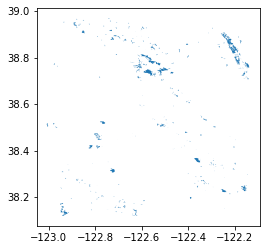

In [60]:
farmland.plot()

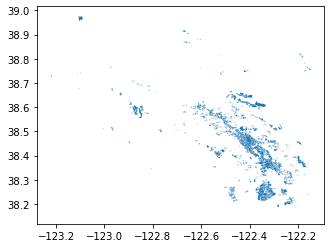

In [61]:
winecountry.plot()

## Plot our openstreetmap data

Let's have a look at the spatial distribution of the data we just downloaded

In [62]:
# Make sure all dfs have the same crs
print(focus_area_gdf.crs, fire_area.crs, edges.crs, farmland.crs, winecountry.crs, buildings.crs, poi.crs)

{'init': 'epsg:4326'} {'init': 'epsg:4326'} {'init': 'epsg:4326'} {'init': 'epsg:4326'} {'init': 'epsg:4326'} {'init': 'epsg:4326'} {'init': 'epsg:4326'}


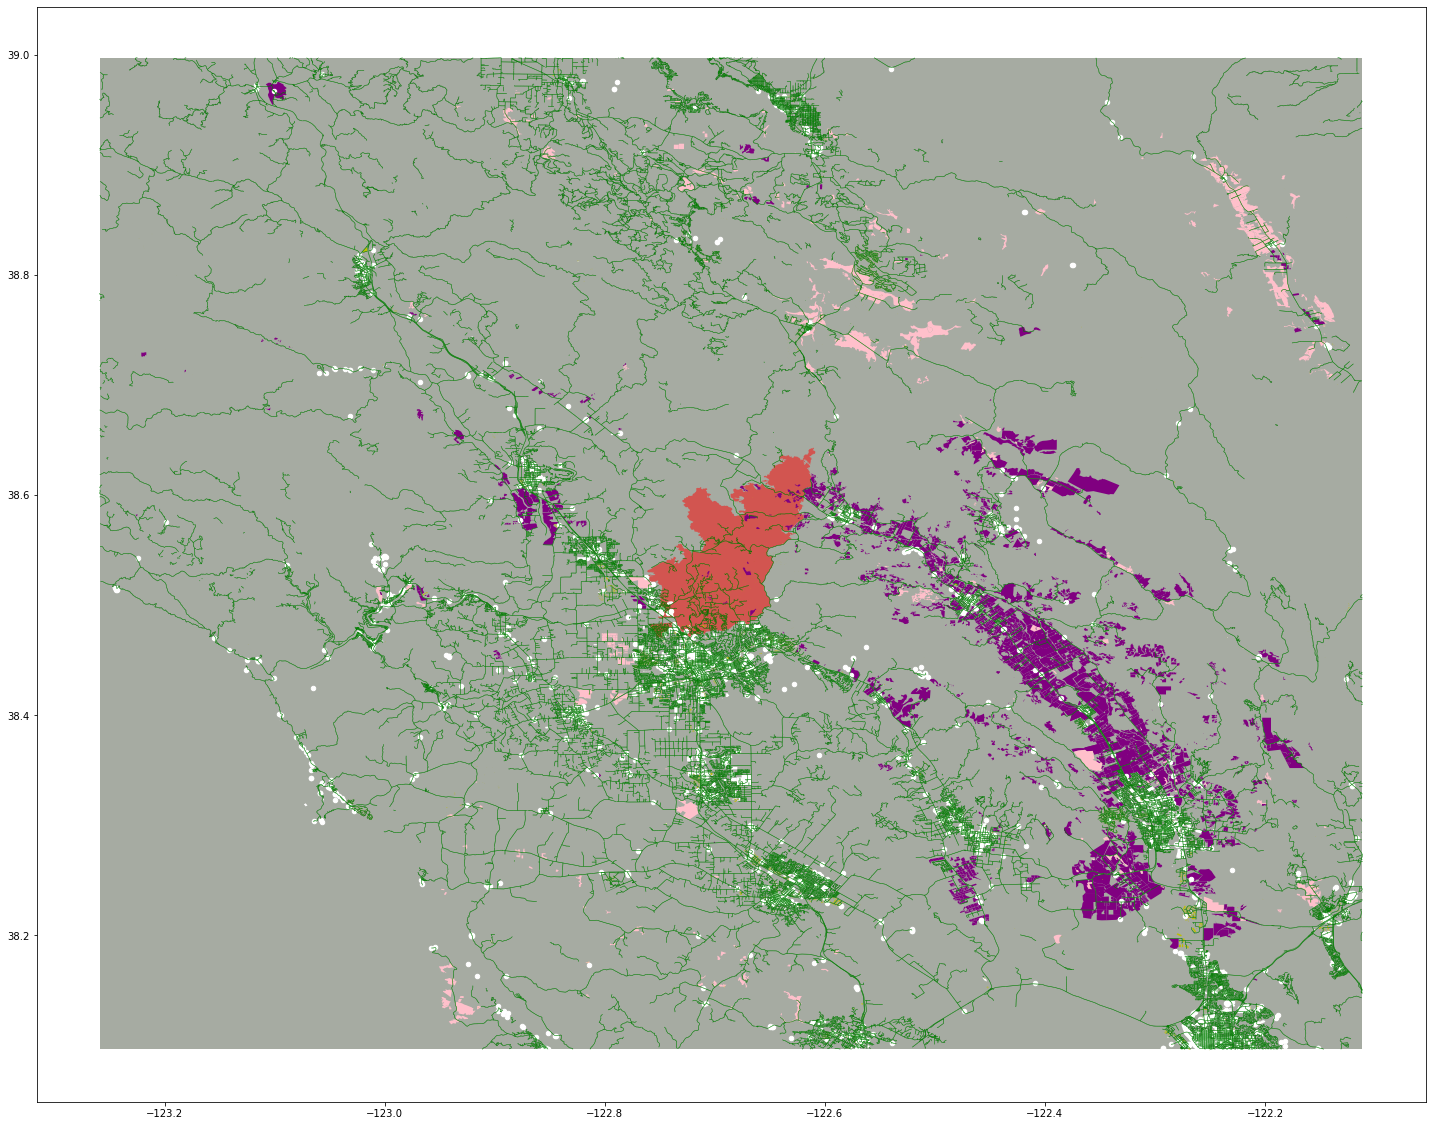

In [63]:
fig, ax  = plt.subplots(figsize = (20, 20))

# Plot our focus area as background
focus_area_gdf.plot(ax = ax, facecolor='#a6aba2')

# Include the fire area
fire_area.plot(ax = ax, facecolor='r', alpha = 0.5)

# Plot street edges
edges.plot(ax=ax, linewidth=0.5, edgecolor='g', alpha  = 0.7)

# Plot wineyard and high value crops
winecountry.plot(ax=ax, facecolor='purple')

# Plot farmland and low value crops
farmland.plot(ax=ax, facecolor='pink')

# Plot buildings
buildings.plot(ax=ax, facecolor='y')

# Plot points of interest
poi.plot(ax=ax, color='w', markersize=20)

plt.tight_layout()

# Spatial merging datasets

Spatial merge the hazard index grid with the points and polygons with economic measures attached to them that we extracted from openstreetmaps.

### Restrict the main data to a single day

In [64]:
main_df.count()

date        518065
level       518065
geometry    518065
dtype: int64

In [65]:
# Reduce to first day to reduce the amount of data for thes processing heavy joins
main_df_raw = main_df
main_df = main_df[main_df.date == dt.datetime(2019, 10, 1)]

In [66]:
main_df.count()

date        69516
level       69516
geometry    69516
dtype: int64

In [118]:
focus_area_gdf = gpd.GeoDataFrame(focus_area_gdf, geometry = focus_area_gdf)

In [119]:
# Restrict the df to the area of interest
main_df = gpd.sjoin(main_df, focus_area_gdf, how='inner', op='intersects')

In [129]:
# drop unnecessary var
main_df = main_df.drop(columns = ['index_right', 0])

In [130]:
main_df.count()

date        6333
level       6333
geometry    6333
dtype: int64

In [131]:
# Have a look at the result
main_df.head()

,date,level,geometry
43851,2019-10-01,5,"POLYGON ((-122.26907 39.09473, -122.26907 39.0..."
43878,2019-10-01,151,"POLYGON ((-123.27526 39.01260, -123.27526 38.9..."
43882,2019-10-01,148,"POLYGON ((-123.22392 39.01260, -123.22392 38.9..."
43937,2019-10-01,45,"POLYGON ((-122.35120 39.01260, -122.35120 38.9..."
43945,2019-10-01,4,"POLYGON ((-122.21773 39.01260, -122.21773 38.9..."


### merge main data + buildings

In [132]:
# have a look at the data to be merged
buildings_df.head()

,ID,geometry,building,amenity,building_area
0,33826998,"POLYGON ((-122.95505 38.18935, -122.95457 38.1...",barn,NaN,"1,085"
1,33827005,"POLYGON ((-122.95429 38.19004, -122.95409 38.1...",yes,NaN,599
2,38819259,"POLYGON ((-122.96676 38.25025, -122.96669 38.2...",yes,NaN,80
3,178234042,"POLYGON ((-122.96495 38.24989, -122.96475 38.2...",yes,restaurant,571
4,215919562,"POLYGON ((-122.93882 38.35589, -122.93872 38.3...",yes,NaN,130


In [133]:
# merge
hazard_joined = gpd.sjoin(main_df, buildings_df, how='left', op='intersects')

In [134]:
# drop unnecessary var
hazard_joined = hazard_joined.drop(columns = 'index_right')

### add points of interest

In [135]:
# have a look at the data to be merged
poi_df.head()

,osmid,geometry,amenity,name,value
126854379,126854379,POINT (-122.70558 38.32603),bar,The Tradewinds,500000
126854387,126854387,POINT (-122.70602 38.32598),bar,Spancky's,500000
150944832,150944832,POINT (-122.92065 38.19939),restaurant,Nick's Cove,500000
290050794,290050794,POINT (-123.01050 38.82313),parking,NaN,50000
309568800,309568800,POINT (-122.13536 38.24362),toilets,NaN,50000


In [136]:
# merge
hazard_joined = gpd.sjoin(hazard_joined, poi_df, how='left', op='intersects')

In [137]:
# drop unnecessary var
hazard_joined = hazard_joined.drop(columns = 'index_right')

### add farmland

In [138]:
# have a look at the data to be merged
farmland_df.head()

,geometry,landuse
116921300,"POLYGON ((-122.79735 38.22163, -122.79627 38.2...",farmyard
116921315,"POLYGON ((-122.81426 38.17564, -122.81376 38.1...",farmyard
116921319,"POLYGON ((-122.94213 38.13556, -122.94118 38.1...",farmyard
116921342,"POLYGON ((-122.91121 38.31673, -122.91133 38.3...",farmyard
116921344,"POLYGON ((-122.93850 38.15846, -122.93799 38.1...",farmland


In [139]:
# merge
hazard_joined = gpd.sjoin(hazard_joined, farmland_df, how='left', op='intersects')

In [140]:
# drop unnecessary var
hazard_joined = hazard_joined.drop(columns = 'index_right')

### add winecountry

In [141]:
# have a look at the data to be merged
winecountry_df.head()

,geometry,landuse
74041976,"POLYGON ((-122.89709 38.45420, -122.89734 38.4...",vineyard
74042160,"POLYGON ((-122.89796 38.45468, -122.89803 38.4...",vineyard
74042249,"POLYGON ((-122.89475 38.45438, -122.89473 38.4...",vineyard
74042360,"POLYGON ((-122.89735 38.45322, -122.89728 38.4...",vineyard
74042409,"POLYGON ((-122.89545 38.45138, -122.89307 38.4...",vineyard


In [142]:
# merge
hazard_joined = gpd.sjoin(hazard_joined, winecountry_df, how='left', op='intersects', rsuffix = 'wine')

In [143]:
# drop unnecessary var
hazard_joined = hazard_joined.drop(columns = 'index_wine')

### add centrality

In [144]:
# have a look at the data to be merged
nodes_df.head()

,geometry,pagerank
55953207,POINT (-123.10196 38.41885),0
55959637,POINT (-122.87007 38.37884),0
55960455,POINT (-122.89769 38.39522),0
55960458,POINT (-122.89690 38.39592),0
55960468,POINT (-122.89652 38.39732),0


In [ ]:
# merge
hazard_joined = gpd.sjoin(hazard_joined, nodes_df, how='left', op='intersects')

In [ ]:
# Have a look at the results from our merges
hazard_joined.head()

In [ ]:
# Save progress
hazard_joined.to_csv('../data/hazard_joined.csv')

In [ ]:
# Also save as pickle
hazard_joined.to_pickle('../data/hazard_joined.pkl')

# Aggregate economic measures by pixel grid

Aggregation by pixel UID:
- Take the first value for columns we got from our main dataset (they are all the same, since we merged multiple objects to the same pixel)
- Count the landuse columns: there will only be one classification per pixel, most likely.
- Sum the value, building area and pagerank columns: These are measures that will have a close correlation with 

In [ ]:
hazard_joined = pd.read_pickle('../data/hazard_joined.pkl')

In [102]:
# Aggregation
hazard_joined_agg = hazard_joined.groupby(hazard_joined.index).agg(geometry = ('geometry', 'first'), 
                                                                   level = ('level', 'first'),
                                                                   date = ('date', 'first'),
                                                                   farm = ('landuse_left', 'count'),
                                                                   wine = ('landuse_wine', 'count'),
                                                                   poi_value = ('value', 'sum'),
                                                                   building_area = ('building_area', 'sum'),
                                                                   pagerank = ('pagerank', 'sum'))

In [103]:
hazard_joined_agg_gdf = gpd.GeoDataFrame(hazard_joined_agg, geometry = 'geometry')

In [104]:
hazard_joined_agg_gdf

,geometry,level,date,farm,wine,poi_value,building_area,pagerank
0,"POLYGON ((-121.06779 42.05171, -121.06779 42.0...",1,2019-10-01,0,0,0,0,0
1,"POLYGON ((-121.09860 42.04144, -121.09860 42.0...",1,2019-10-01,0,0,0,0,0
2,"POLYGON ((-121.08833 42.04144, -121.08833 42.0...",3,2019-10-01,0,0,0,0,0
3,"POLYGON ((-121.07806 42.04144, -121.07806 42.0...",4,2019-10-01,0,0,0,0,0
4,"POLYGON ((-121.03699 42.04144, -121.03699 42.0...",2,2019-10-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...
69601,"POLYGON ((-119.17861 36.91807, -119.17861 36.9...",4,2019-10-01,0,0,0,0,0
69602,"POLYGON ((-119.16835 36.91807, -119.16835 36.9...",3,2019-10-01,0,0,0,0,0
69603,"POLYGON ((-119.14781 36.91807, -119.14781 36.9...",7,2019-10-01,0,0,0,0,0
69604,"POLYGON ((-119.13754 36.91807, -119.13754 36.9...",3,2019-10-01,0,0,0,0,0


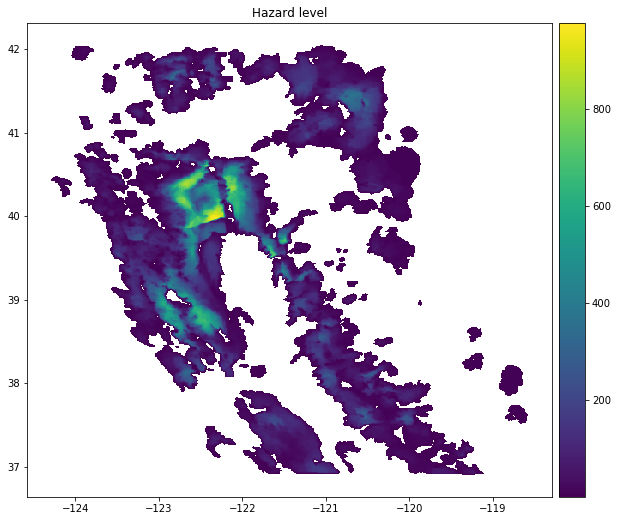

In [105]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

hazard_joined_agg_gdf.plot(column='level', ax=ax, legend=True, cax=cax)

ax.set_title('Hazard level')

plt.show()

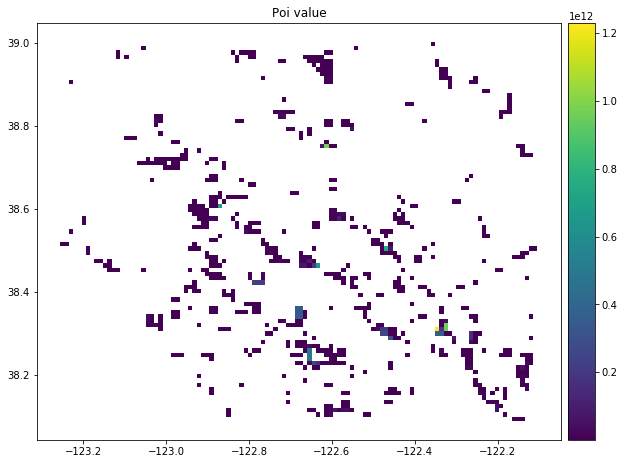

In [106]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

hazard_joined_agg_gdf[hazard_joined_agg_gdf.poi_value > 0].plot(column='poi_value', ax=ax, legend=True, cax=cax)

ax.set_title('Poi value')

plt.show()